# Long Notebook - Active

#### Emil B. Berglund - 529222 & Louis H. H. Linnerud - 539305, Team: Stacked SR Boost

#### Table of contents:
1. Exploratory data analysis
2. Feature Engineering 
3. Models/Predictors
    - LightGBM
    - Random Forest Regressor
4. Model Interpretations
    - feature importance



# ___________ _0. Setup_ ___________

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
import catboost as cb
import xgboost as xg
import featuretools as ft
import category_encoders as ce
import shap
import h2o
from h2o.automl import H2OAutoML
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder
from sklearn.neighbors import BallTree, KDTree




#from pandas_profiling import ProfileReport

In [2]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [3]:
def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)**0.5

___

# ___________ _1. Exploratory Data Analysis_ ___________


#### Domain Knowledge

Retailers obviously earn their revenue from sales, different retailers sell different products to different customers. Different products have different margins and number of sales, directly impacting the revenue. Number of sales most likely have a high correlation with number of costumers, areas with a high population density will therefor most likely have a higher number of customers, impacting number of sales and then impacting the revenue. Therefor retailer type and geographical position most likely have a high impact on revenue. Only knowing those two attributes can be a good pin pointer, but not necessary enough as described in this article: https://carto.com/blog/retail-revenue-prediction-data-science/. Area infrastructure, retailer reputation, market competition, inventory managements, customer type, sales strategy and a lot more factors impact revenue and makes this problem complex. further reading on some of these factors: https://smallbusiness.chron.com/calculate-percentage-profit-markups-business-60099.html


#### Is the data intuitiv?

As can be seen below, data is organized in rows, where each row represents a single retailer with its relevant attributes and revenue. The stores train, extra and test data is intuitiv.

The different grunnkrets data was not super intuitv before some exploration was done, the same grunnkrets_id appeard more than once, but we shortly realized that this is because the measurment (example: average income) is done twice, once in 2015 and once in 2016.

In [ ]:
stores_train = pd.read_csv('data/stores_train.csv')


In [ ]:
stores_train.head()

In [ ]:
stores_train.info()

In [ ]:
stores_train.describe()

In [ ]:
#report = ProfileReport(stores_train)
#report

#### Explore individual features and pairs and groups

Explore revenue based on store type

In [ ]:
len(stores_train.plaace_hierarchy_id.unique())

In [ ]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

In [ ]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

Further exploration of "Food and drink" type stores


In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with NaN, 0 or negative revenue

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["revenue"] < 0.0].describe()

In [ ]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]== np.nan].describe()

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the long tail to the right of the major distribution.
The data is clearly positively skewed, confirmed by the skew number printed above the plot

In [ ]:
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(stores_train['revenue'], ax=ax1);
ax1.set_title('Distribution revenue');
sns.distplot(rev_log['revenue_log'], ax=ax2);
ax2.set_title('Distribution of revenue after log transform');

print(f"raw data skew: {stores_train['revenue'].skew()}")
print(f"log transform skew: {rev_log['revenue_log'].skew()}")

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [4]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [ ]:
remove_columns(stores_train,['year'])
stores_train.head()

#### Remove retailers with 0 revenue function - might be handy

In [ ]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

Below is before trimming

In [ ]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

Cap-outliers-function for the relationship between store type and revenue

In [ ]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    col_idx = stores.columns.get_loc('revenue')
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
        
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index,[col_idx]] = upper_treshold
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index,[col_idx]] = lower_treshold
        
    

In [ ]:
stores_train = pd.read_csv('data/stores_train.csv')
quantile_storeType_vs_revenue(stores_train,0.05,0.86)

Plot after removing outliers

you can see in the plot below that the outliers has been removed


In [ ]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

In [ ]:
stores_train = pd.read_csv('data/stores_train.csv')
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

rev_capped_log = stores_train.copy()
quantile_storeType_vs_revenue(rev_capped_log, 0.03, 0.90)
rev_capped_log['revenue'] = np.log1p(rev_capped_log['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(rev_log['revenue_log'], ax=ax1, bins=91);
ax1.set_title('Distribution log transformed revenue');
sns.distplot(rev_capped_log['revenue'], ax=ax2, bins=91);
ax2.set_title('Distribution capped log transform revenue');

Quantiling the data improved our predictions greatly in the beginning of the project, but we saw that it didnt have a noticable impact after we began exploring log transform, the plot above shows that quantiling does not improve distribution with log transform

#### compare store locations in test and train set

In [ ]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

In [ ]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



In [ ]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lon'],stores_train['lat'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [ ]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.head()

### Explore the other data sets

In [108]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

,busstop_id,stopplace_type,importance_level,side_placement,geometry
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553)
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075)
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761)
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692)
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898)


In [110]:
print(buss_stopps.stopplace_type.unique())
print(buss_stopps.importance_level.unique())

['Plattform og lomme' 'Lomme og skilt, ikke plattform' nan 'Annen type'
 'Kun skilt' 'Kantstopp' 'Signalstopp']
['Mangler viktighetsnivå' 'Standard holdeplass' 'Lokalt knutepunkt'
 'Nasjonalt knutepunkt' 'Regionalt knutepunkt' 'Annen viktig holdeplass']


In [129]:
buss_stopps[buss_stopps['importance_level'] == 'Nasjonalt knutepunkt'].tail(5)

,busstop_id,stopplace_type,importance_level,side_placement,geometry,lat,lon
68016,ae460f52-1dc7-4c2e-bdc0-6460d90ed9a8,Plattform og lomme,Nasjonalt knutepunkt,MIDDLE,POINT(7.16165503576015 62.7372587553647),62.737259,7.161655
68040,3ec931c0-4ade-4918-96e2-d62d05583f44,NaN,Nasjonalt knutepunkt,MIDDLE,POINT(16.1232664089857 69.3109963936699),69.310996,16.123266
68122,8cad3308-86a4-475d-a97f-bb5a0c962124,Annen type,Nasjonalt knutepunkt,MIDDLE,POINT(11.5626748265289 60.8778229290206),60.877823,11.562675
68123,62648ff8-9a12-4df0-84dd-604efc304a82,Annen type,Nasjonalt knutepunkt,MIDDLE,POINT(11.5635822735424 60.8777933293551),60.877793,11.563582
68124,d73ff6a4-417a-4bdb-a89d-c503de6e438b,Annen type,Nasjonalt knutepunkt,MIDDLE,POINT(11.5644270817502 60.8778982629558),60.877898,11.564427


In [ ]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

From exploring the the houshold income we can see that the distribution is somewhat negatively skewed but very evenly distributed, probably no need for any log transformation of this feature

In [ ]:
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')

upper_33 = gk_incomes['all_households'].quantile(0.67)
lower_33 = gk_incomes['all_households'].quantile(0.33)
maximum = gk_incomes['all_households'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.all_households, bins=[0,lower_33, upper_33, maximum], labels=['low','medium','high'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(gk_incomes['all_households'], ax=ax1);
ax1.set_title('Distribution mean houshold income in grunnkrets');
sns.distplot(np.log1p(gk_incomes['all_households']), ax=ax2);
ax2.set_title('Distribution of log transformed mean houshold income in grunnkrets');
plt.show()


gk_incomes.head()

The plot below tries to illustrate top and bottom 20% distribution of household income, however it is somewhat imprecise as the data is plotted as its own distribution based on low, medium or high and not as a whole, just coloring based on value

In [ ]:
upper = gk_incomes['all_households'].quantile(0.80)
lower = gk_incomes['all_households'].quantile(0.20)
maximum = gk_incomes['all_households'].max()
gk_incomes['incomeclassification'] = pd.cut(gk_incomes.all_households, bins=[0,lower, upper, maximum], labels=['low','medium','high'])

sns.displot(data=gk_incomes, x='all_households', hue='incomeclassification')

In [ ]:
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_households.head()

In [ ]:
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
gk_ages.head()

___

# ___________ _2. Feature Engineering_ ___________

In [116]:
stores_train = pd.read_csv('data/stores_train.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
buss_stopps = pd.read_csv('data/busstops_norway.csv')
hierarchy = pd.read_csv('data/plaace_hierarchy.csv')

grunnkrets.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_incomes.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_households.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_ages.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
buss_stopps.drop_duplicates(subset=['busstop_id'], inplace=True)



Grunnkrets

In [117]:
municipality_area = grunnkrets.groupby('municipality_name').area_km2.transform('sum')
grunnkrets['municipality_area'] = municipality_area

grunnkrets.head()

,grunnkrets_id,year,grunnkrets_name,district_name,municipality_name,geometry,area_km2,municipality_area
0,10010701,2015,Grim-Dueknipen,Grim-Møllevann-Dalane,Kristiansand,MULTIPOLYGON(((7.97199691121304 58.14336769560...,0.768961,48.018692
1,10010803,2015,Kvadraturen sørøst,Kvadraturen-Eg,Kristiansand,"POLYGON((8.00234207061135 58.1443514886041, 8....",0.361355,48.018692
2,10020608,2015,Ormestad,Holum,Mandal,"POLYGON((7.48512808482995 58.0374976883392, 7....",0.280188,17.017158
3,10020901,2015,Tregde,Tregde-Skjernøy,Mandal,MULTIPOLYGON(((7.50996051810658 58.02134863868...,0.156311,17.017158
4,10030210,2015,Bryneheia,Vanse/Åpta,Farsund,"POLYGON((6.70396719073296 58.0877854965615, 6....",0.791894,46.308421


Income

In [118]:
gk_incomes.rename(columns = {'all_households':'income_gk'}, inplace = True)

# income in district
gk_districts = grunnkrets[['grunnkrets_id','district_name']]
gk_incomes = pd.merge(gk_incomes, gk_districts, how='left', on='grunnkrets_id')

income_district = gk_incomes.groupby(['district_name']).income_gk.transform('mean')
gk_incomes['income_district'] = income_district
gk_incomes['income_district_log'] = np.log1p(income_district)

# Mean revenue in district
gk_revenues = pd.DataFrame(stores_train[['grunnkrets_id','revenue']])
gk_revenues.rename(columns = {'revenue':'revenue_gk'}, inplace = True)
gk_revenues = gk_revenues.groupby('grunnkrets_id').revenue_gk.mean()
gk_incomes = pd.merge(gk_incomes, gk_revenues, how='left', on='grunnkrets_id')
#gk_incomes['revenue_gk'].fillna(0,inplace=True)
gk_incomes['mean_rev_district'] = gk_incomes.groupby(['district_name']).revenue_gk.transform('mean')
gk_incomes['mean_rev_district_log'] = np.log1p(gk_incomes['mean_rev_district'])

# label income in district as low medium high
""" upper = gk_incomes['income_district'].quantile(0.80)
lower = gk_incomes['income_district'].quantile(0.20)
maximum = gk_incomes['income_district'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.income_district, bins=[0,lower, upper, maximum], labels=[1,2,3]) """

# label income in gk as low medium high
upper = gk_incomes['income_gk'].quantile(0.80)
lower = gk_incomes['income_gk'].quantile(0.20)
maximum = gk_incomes['income_gk'].max()
gk_incomes['income_classification'] = pd.cut(gk_incomes.income_gk, bins=[0,lower, upper, maximum], labels=['low','medium','high'])


#gk_incomes.head(5)


Ages

In [119]:
# Merge in selected columns
gk_area = grunnkrets[['grunnkrets_id','area_km2','municipality_area','municipality_name','district_name']]
gk_ages = pd.merge(gk_ages, gk_area, how='left', on='grunnkrets_id')

# Number of people features in grunnkrets
tot_people_in_gk = np.sum(gk_ages.iloc[:,np.arange(2,93,1)], axis=1)
gk_ages['tot_people_gk'] = tot_people_in_gk

# Number of people features in municipality
tot_people_in_municipality = gk_ages.groupby('municipality_name').tot_people_gk.transform('sum')
gk_ages['tot_people_municipality'] = tot_people_in_municipality

# Number of people features in district
tot_people_in_district = gk_ages.groupby('district_name').tot_people_gk.transform('sum')
gk_ages['tot_people_district'] = tot_people_in_district

# People density gk
gk_ages['people_density_gk'] = (gk_ages['tot_people_gk'] / gk_ages['area_km2'])
gk_ages['people_density_gk_log'] = np.log1p(gk_ages['tot_people_gk'] / gk_ages['area_km2'])

# People density municipality
gk_ages['people_density_municipality'] = (gk_ages['tot_people_municipality'] / gk_ages['municipality_area'])
gk_ages['people_density_municipality_log'] = np.log1p(gk_ages['tot_people_municipality'] / gk_ages['municipality_area'])

# People density district
district_area_km2 = gk_ages.groupby('municipality_name').area_km2.transform('sum')
gk_ages['district_area_km2'] = district_area_km2

gk_ages['people_density_district'] = (gk_ages['tot_people_district'] / gk_ages['district_area_km2'])
gk_ages['people_density_district_log'] = np.log1p(gk_ages['people_density_district'])




# City name
gk_ages['city'] = "none"
col_idx = gk_ages.columns.get_loc('city')
for mun in gk_ages['municipality_name'].unique():
        gk_ages.iloc[gk_ages[(gk_ages['municipality_name']==mun) & (gk_ages['tot_people_municipality']>100000)].index,[col_idx]] = mun




gk_ages.head(5)



,grunnkrets_id,year,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,tot_people_municipality,tot_people_district,people_density_gk,people_density_gk_log,people_density_municipality,people_density_municipality_log,district_area_km2,people_density_district,people_density_district_log,city
0,16013117,2015,14,14,14,14,13,13,12,11,...,183366,9305,13276.775063,9.493847,1274.839344,7.151360,124.535620,74.717579,4.327010,Trondheim
1,11030206,2015,5,5,5,5,5,4,4,3,...,130547,4065,6239.892860,8.738879,2152.071656,7.674651,55.864804,72.764956,4.300884,Stavanger
2,16011203,2016,2,2,2,2,2,3,3,3,...,183366,9324,9224.102158,9.129684,1274.839344,7.151360,124.535620,74.870146,4.329023,Trondheim
3,3011601,2016,7,7,7,7,6,6,5,4,...,655976,6261,18981.134917,9.851254,4692.839429,8.454006,127.673762,49.039050,3.912804,Oslo
4,3010308,2015,7,7,7,7,7,6,6,5,...,655976,5083,13875.630626,9.537961,4692.839429,8.454006,127.673762,39.812409,3.708986,Oslo


Households

In [120]:
gk_municipalities = grunnkrets[['grunnkrets_id','municipality_name']]

# Number of house holds grunnkrets level
gk_households['nb_households_gk']  = np.sum(gk_households.iloc[:,np.arange(2,10,1)], axis=1)
gk_households['nb_households_gk_log']  = np.log1p(gk_households['nb_households_gk'])

# Number of house holds municipality level
gk_households = pd.merge(gk_households, gk_municipalities, how='left', on='grunnkrets_id')
nb_housholds_municipality = gk_households.groupby('municipality_name').nb_households_gk.transform('sum')
gk_households['nb_households_municipality'] = nb_housholds_municipality
gk_households['nb_households_municipality_log'] = np.log1p(nb_housholds_municipality)


gk_households.head()




,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles,nb_households_gk,nb_households_gk_log,municipality_name,nb_households_municipality,nb_households_municipality_log
0,12010509,2015,0,0,4,0,0,0,0,4,8,2.197225,Bergen,275894,12.527776
1,14390206,2015,0,7,0,0,0,0,0,3,10,2.397895,Vågsøy,5753,8.657651
2,18040514,2015,10,0,0,0,0,0,0,7,17,2.890372,Bodø,48360,10.786449
3,18040804,2015,0,0,0,0,0,0,0,0,0,0.000000,Bodø,48360,10.786449
4,18200101,2015,0,6,0,0,0,0,0,4,10,2.397895,Alstahaug,7075,8.864464


In [121]:
def add_hierarchy(stores):
    chosen_hiercs = hierarchy[['plaace_hierarchy_id','lv2_desc','lv3_desc']]
    stores_with_hierarchy = pd.merge(stores,chosen_hiercs, how='inner', on='plaace_hierarchy_id')
    stores['lv2_desc'] = stores_with_hierarchy['lv2_desc']
    stores['lv3_desc'] = stores_with_hierarchy['lv3_desc']
    

Buss stops

In [122]:
# Number of buss stops

def add_latlong(buss):
    buss['lat'] = 0.0
    buss['lon'] = 0.0
    lonList = []
    latList = [] 
    for index, row in buss.iterrows():
        lon = row['geometry']
        lon = lon[6:]
        lon = lon.replace(')','')
        
        lat = lon.split()[1]
        lon = lon.split()[0]
        lon = float(lon)
        lat = float(lat) 

        lonList.append(lon)
        latList.append(lat)
        
    buss['lon'] = np.array(lonList)
    buss['lat'] = np.array(latList)

""" def euclidian_dist(X, Y):
    sx = np.sum(X**2, keepdims=True)
    sy = np.sum(Y**2, axis=1, keepdims=True)
    return np.sqrt(-2 * X.dot(Y.T) + sx + sy.T)

def busstop_distances(store, bus):
    print("Calculating busstops")
    busMat = bus[['lat', 'lon']]
    busMat = busMat.to_numpy()

    storeMat = store[['lat', 'lon']]
    storeMat = storeMat.to_numpy()

    mins = []
    withinx = []
    withiny = []
    withinz = []
    for row in storeMat:
        res = euclidian_dist(row, busMat)

        res = res.flatten()
        mins.append(min(res))
        withinx.append(len(res[res<0.1]))
        withiny.append(len(res[res<0.05]))
        withinz.append(len(res[res<0.005]))
    
    store['closestBusStop'] = np.array(mins)
    store['closestBusStop_log'] = np.log1p(store['closestBusStop']*10000)
    store['busStopsWithinXkm'] = np.array(withinx)
    store['busStopsWithinYkm'] = np.array(withiny)
    store['busStopsWithinZKm'] = np.array(withinz) """;


In [123]:
add_latlong(buss_stopps)

In [124]:
""" def add_busstops(stores):
    busstop_distances(stores, buss_stopps) """;

new buss

In [177]:
def add_buss_feats(stores,r1=0.3,r2=5,r3=10):
    k_neighbors =1200
    minutes = 60 #minutes
    nautic = 1.852 #km
    
    buss_stopps[["lat_rad", "lon_rad"]] = np.deg2rad(buss_stopps[["lat", "lon"]])
    stores[["lat_rad", "lon_rad"]] = np.deg2rad(stores[["lat", "lon"]])
    
    tree = BallTree(buss_stopps[["lat_rad", "lon_rad"]].values, metric='haversine')

    distances, indices = tree.query(stores[["lat_rad", "lon_rad"]], k = k_neighbors)
    distances = np.rad2deg(distances) # convert back to radians
    distances_km = distances*minutes*nautic
    nb_stops_r1 = np.count_nonzero(distances_km < r1, axis=1)
    nb_stops_r2 = np.count_nonzero(distances_km < r2, axis=1)
    nb_stops_r3 = np.count_nonzero(distances_km < r3, axis=1)
    dist_closest_bus = np.min(distances_km,axis=1)
    
    stores['dist_closest_bus'] = dist_closest_bus
    stores['dist_closest_bus_transformed'] = np.log1p(dist_closest_bus*10000)
    stores['nb_stops_r1'] = nb_stops_r1
    stores['nb_stops_r2'] = nb_stops_r2
    stores['nb_stops_r3'] = nb_stops_r3
    
    # Important stops
    important_buss_stops = buss_stopps[buss_stopps['importance_level'] == 'Nasjonalt knutepunkt']
    
    tree = BallTree(important_buss_stops[["lat_rad", "lon_rad"]].values, metric='haversine')

    distances, indices = tree.query(stores[["lat_rad", "lon_rad"]], k = 2) #2 because we eperienced some unstability with 1
    distances = np.rad2deg(distances) # convert back to radians
    distances_km = distances*minutes*nautic
    dist_closest_important_stop = np.min(distances_km,axis=1)
    
    stores['dist_closest_important_stop'] = dist_closest_important_stop
    stores[stores['dist_closest_important_stop'] < 0.00001] = np.max(dist_closest_important_stop,axis=0)#.replace(to_replace = 0,  value= np.max(dist_closest_important_stop), inplace=True)
    
    stores['dist_closest_important_stop_transformed'] = np.log1p(dist_closest_important_stop)


Store set

In [159]:
def self_aggregate_columns (stores):
    # has mall ~ dropped "has_mall" as it had low impact seen in feature engineering plots
    #stores['mall_name'] = stores['mall_name'].fillna('0')
    #stores['has_mall'] = stores['mall_name'].apply(lambda x: 1 if x !='0' else 0)


    # has chain
    stores['chain_name'] = stores['chain_name'].fillna('0')
    stores['has_chain'] = stores['chain_name'].apply(lambda x: 1 if x !='0' else 0)


    # Distance to another store


    # Distance to another store of same type


    # Number of similar stores in municipality
    gk_municipalities = grunnkrets[['grunnkrets_id','municipality_name']]
    stores = pd.merge(stores, gk_municipalities, how='left', on='grunnkrets_id')
    
    nb_similar_stores_municipality = stores.groupby(['municipality_name','plaace_hierarchy_id']).plaace_hierarchy_id.transform('count')
    stores['nb_similar_stores_municipality'] = nb_similar_stores_municipality
    

    # lat lon log transform ~ dropped as it had little effect
    #stores['lat_log'] = np.log1p(stores['lat'])
    #stores['lon_log'] = np.log1p(stores['lon'])
    
    
    # closest competitor
    stores_ex = pd.read_csv('data/stores_extra.csv')
    stores_tr = pd.read_csv('data/stores_train.csv')
    stores_te = pd.read_csv('data/stores_test.csv')
    minutes=60
    nautic=1.852 #km    

    all_stores = stores_ex.copy()
    all_stores = all_stores.append(stores_tr)
    all_stores = all_stores.append(stores_te)

    all_stores[["lat_rad", "lon_rad"]] = np.deg2rad(all_stores[["lat", "lon"]])
    stores[["lat_rad", "lon_rad"]] = np.deg2rad(stores[["lat", "lon"]])
    
    stores['dist_closest_comp_km'] = 0
    
    for store_type in stores['plaace_hierarchy_id'].unique():
        
        temp_all_df = all_stores.loc[all_stores['plaace_hierarchy_id']==store_type]
        temp_target_df = stores.loc[stores['plaace_hierarchy_id']==store_type, ['store_id','lat_rad','lon_rad']]
        
        if temp_target_df.shape[0] > 1:
            tree = BallTree(temp_all_df[["lat_rad", "lon_rad"]].values, metric='haversine')
            
            distances, indices = tree.query(temp_target_df[["lat_rad", "lon_rad"]], k = 2)
            
            #distances = np.rad2deg(distances) # convert back to radians #TODO this has been forgotten, check if it improves result here and at the above one 

            distances_km = distances*minutes*nautic
            
            temp_target_df["dist_closest_comp_km_temp"] =np.max(distances_km, axis=1)
            
            temp_target_df.drop(['lat_rad','lon_rad'],axis=1, inplace=True)
            stores = pd.merge(stores, temp_target_df, how='left', on='store_id')
            stores['dist_closest_comp_km_temp'].fillna(0, inplace=True)
            
            stores['dist_closest_comp_km'] = stores['dist_closest_comp_km'] + stores['dist_closest_comp_km_temp']
            stores.drop('dist_closest_comp_km_temp', axis=1, inplace=True)
    
    # closest competitor transformed
    stores['dist_closest_comp_km_transform'] = stores['dist_closest_comp_km']
    stores['dist_closest_comp_km_transform'].replace(to_replace = 0,  method='ffill', inplace=True)
    #stores['dist_closest_comp_km_transform'].replace(to_replace = 0,  value=stores['dist_closest_comp_km_transform'].mean(), inplace=True)#made no diff??
    stores['dist_closest_comp_km_transform'] = np.log1p(stores['dist_closest_comp_km_transform'])#*10000)
    
    
    #closest competitor in chain
    stores['dist_closest_chain_km'] = 0

    for chain in stores['chain_name'].unique():
        
        temp_all_df = all_stores.loc[all_stores['chain_name']==chain]
        temp_target_df = stores.loc[stores['chain_name']==chain, ['store_id','lat_rad','lon_rad']]
        
        if temp_target_df.shape[0] > 1 and temp_all_df.shape[0] > 1 :
            tree = BallTree(temp_all_df[["lat_rad", "lon_rad"]].values, metric='haversine')
            
            distances, indices = tree.query(temp_target_df[["lat_rad", "lon_rad"]], k = 2)

            distances_km = distances*minutes*nautic
            
            temp_target_df["dist_closest_chain_km_temp"] =np.max(distances_km, axis=1)
            
            temp_target_df.drop(['lat_rad','lon_rad'],axis=1, inplace=True)
            stores = pd.merge(stores, temp_target_df, how='left', on='store_id')
            stores['dist_closest_chain_km_temp'].fillna(0, inplace=True)
            
            stores['dist_closest_chain_km'] = stores['dist_closest_chain_km'] + stores['dist_closest_chain_km_temp']
            stores.drop('dist_closest_chain_km_temp', axis=1, inplace=True)

    # closest chain transformed
    stores['dist_closest_chain_km_transform'] = stores['dist_closest_chain_km']
    stores['dist_closest_chain_km_transform'].replace(to_replace = 0,  method='ffill', inplace=True)
    #stores['dist_closest_chain_km_transform'].replace(to_replace = 0,  value=stores['dist_closest_chain_km_transform'].mean(), inplace=True)#made no diff??
    stores['dist_closest_chain_km_transform'] = np.log1p(stores['dist_closest_chain_km_transform'])#*10000)
    
    
    # Number of stores within range
    tree = BallTree(all_stores[["lat_rad", "lon_rad"]].values, metric='haversine')
    
    distances , indices = tree.query(stores[["lat_rad", "lon_rad"]], k = 1000)
    distances = np.rad2deg(distances) # convert back to radians
    distances_km = distances*minutes*nautic
    
    r = 0.6 #km
    nb_stores_r = np.count_nonzero(distances_km < r, axis=1)
    stores['nb_stores_r'] = nb_stores_r
    stores['nb_stores_r_transformed'] = np.log1p(nb_stores_r)
    
    
    
    remove_columns(stores,['municipality_name'])# revert action, gets added later
    return stores



Concat columns

In [132]:
def add_selected_columns(df, include_bad_columns=False):
    df = self_aggregate_columns(df)
    #add_busstops(df)
    add_buss_feats(df)
    add_hierarchy(df)
    gk = grunnkrets[['grunnkrets_id','municipality_name', 'district_name']]
    gk_i = gk_incomes[['grunnkrets_id','income_gk','income_classification','income_district','mean_rev_district','mean_rev_district_log','income_district_log']]
    gk_h = gk_households[['grunnkrets_id','nb_households_gk','nb_households_municipality','nb_households_gk_log','nb_households_municipality_log']]
    gk_a = gk_ages[['grunnkrets_id','tot_people_gk','tot_people_district','tot_people_municipality','people_density_gk_log','people_density_municipality_log','people_density_gk','people_density_municipality','city','people_density_district','people_density_district_log']]
    
    concat = pd.merge(df, gk, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_i, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_h, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_a, how='left', on='grunnkrets_id')
    
    # NaN handling
    concat['municipality_name'].fillna('0', inplace=True)
    concat['income_classification'].fillna('medium', inplace=True)
    concat['nb_similar_stores_municipality'].fillna(0, inplace=True)
    concat['income_gk'].fillna(450000, inplace=True)
    concat['city'].fillna('none', inplace=True)
    concat['people_density_district'].fillna(concat['people_density_district'].dropna().mean(), inplace=True)#the mean value
    concat['people_density_district_log'].fillna(concat['people_density_district_log'].dropna().mean(), inplace=True)        
    concat['district_name'].fillna('none', inplace=True)
    concat['mall_name'].fillna('none', inplace=True)
    concat['income_district'].fillna(466285.26671004744, inplace=True) #replace with mean value
    concat['mean_rev_district'].fillna(8.20564984134999, inplace=True) #replace with mean value
    #concat['tot_people_gk'].fillna(concat['tot_people_gk'].dropna().mean(), inplace=True)
    concat['tot_people_district'].fillna(concat['tot_people_district'].dropna().mean(), inplace=True)
    concat['tot_people_municipality'].fillna(concat['tot_people_municipality'].dropna().mean(), inplace=True)        
    concat['people_density_gk_log'].fillna(concat['people_density_gk_log'].dropna().mean(), inplace=True)
    concat['people_density_municipality_log'].fillna(concat['people_density_municipality_log'].dropna().mean(), inplace=True)
    concat['people_density_gk'].fillna(concat['people_density_gk'].dropna().mean(), inplace=True)
    concat['people_density_municipality'].fillna(concat['people_density_municipality'].dropna().mean(), inplace=True)
    
    # Remove columns that dont contribute positively to the result
    if not include_bad_columns:
        remove_columns(concat, [
                                'store_id',
                                'store_name',
                                'year',
                                'address',
                                #'sales_channel_name',
                                #'lv2_desc',
                                #'lv3_desc',
                                'grunnkrets_id',
                                'lat',
                                'lon',
                                #'lat_rad',
                                #'lon_rad',
                                #'chain_name',
                                #'mall_name',
                                #'has_chain',
                                #'municipality_name',
                                #'district_name',
                                #'income_gk',
                                'income_district',
                                'income_district_log',# use unlogged column instead due to weird distribution somehow
                                'mean_rev_district_log', #make things alot worse on kaggle
                                'mean_rev_district',
                                #'income_classification',
                                'nb_similar_stores_municipality',
                                'nb_households_gk',
                                'nb_households_gk_log',
                                'nb_households_municipality', #very ugly distributed
                                'nb_households_municipality_log',
                                'tot_people_gk',
                                #'tot_people_district',
                                'tot_people_municipality', # should be removed, very poor distribution
                                'people_density_gk', # this distributibution is suuuuperweird compared in the different sets..
                                'people_density_gk_log',
                                'people_density_municipality',
                                'people_density_municipality_log',
                                #'dist_closest_bus',
                                'dist_closest_bus_transformed',
                                #'nb_stops_r1',
                                #'nb_stops_r2',
                                #'nb_stops_r3',
                                #'dist_closest_important_stop'
                                #'dist_closest_important_stop_transformed'
                                #'nb_stores_r',
                                'nb_stores_r_transformed',
                                #'dist_closest_comp_km',
                                #'dist_closest_comp_km_transform',
                                'dist_closest_chain_km',
                                #'dist_closest_chain_km_transform',
                                #'city',
                                'people_density_district',
                                #'people_density_district_log'
                                ])
    
    
    return concat
#Bokmerke

### Inspecting features

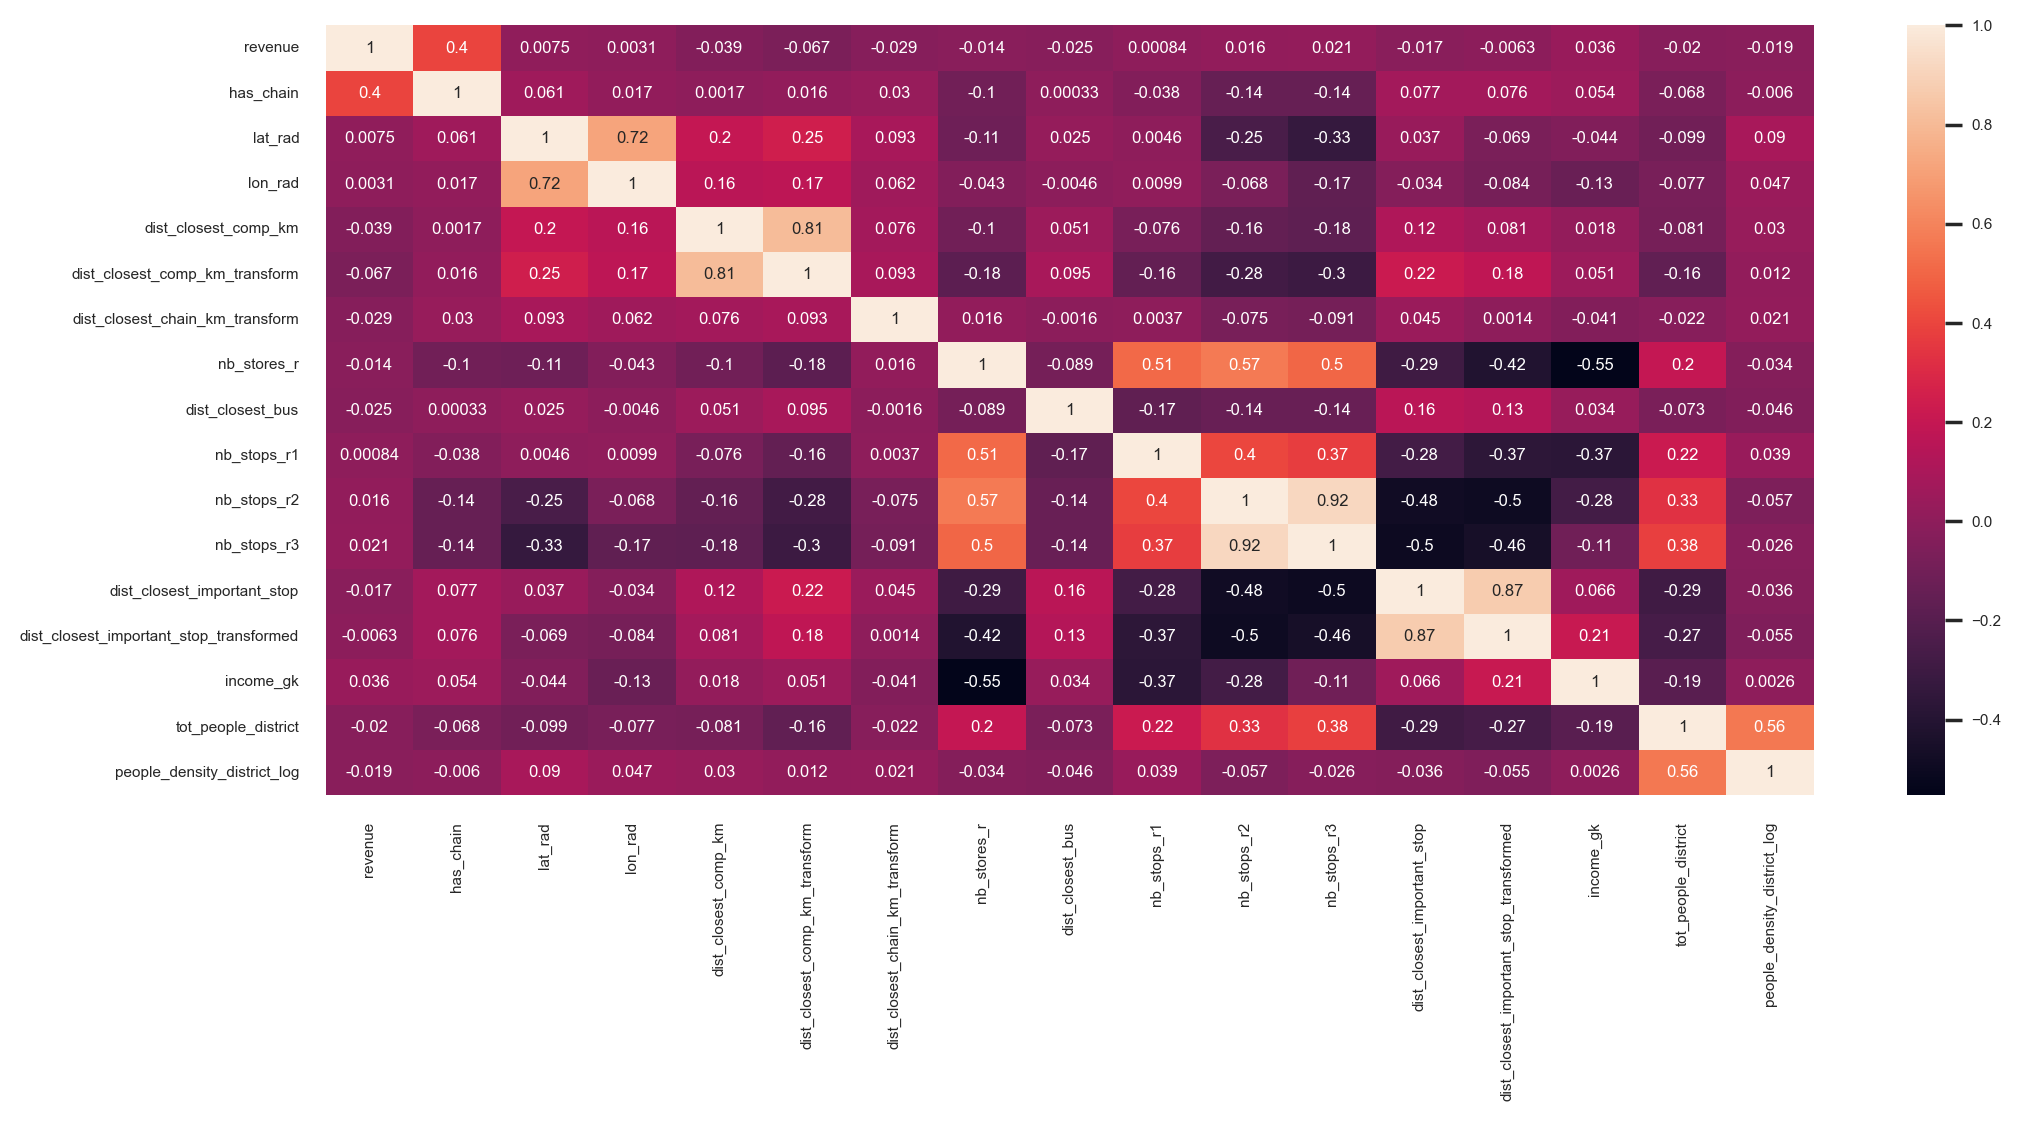

In [152]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_train = add_selected_columns(stores_train, include_bad_columns=False) # includes the bad columns so we can demonstrate that they are actually bad

sns.set(font_scale=0.5)
plt.figure(figsize=(12,5), dpi=200)
sns.heatmap(stores_train.corr(), annot=True)
plt.show()

In [153]:
print(stores_train.isnull().sum())
#print(stores_train.dtypes)
#stores_train.iloc[:,[1,8,9,10,11,12,16,23,24,25]].head()
#plt.figure(figsize=(12,5), dpi=200)
#sns.pairplot(stores_train)
#plt.show()


plaace_hierarchy_id                        0
sales_channel_name                         0
chain_name                                 0
mall_name                                  0
revenue                                    0
has_chain                                  0
lat_rad                                    0
lon_rad                                    0
dist_closest_comp_km                       0
dist_closest_comp_km_transform             0
dist_closest_chain_km_transform            0
nb_stores_r                                0
dist_closest_bus                           0
nb_stops_r1                                0
nb_stops_r2                                0
nb_stops_r3                                0
dist_closest_important_stop                0
dist_closest_important_stop_transformed    0
lv2_desc                                   0
lv3_desc                                   0
municipality_name                          0
district_name                              0
income_gk 

In [154]:
stores_test = pd.read_csv('data/stores_test.csv')
stores_test = add_selected_columns(stores_test, include_bad_columns=False)

In [155]:
print(stores_test.isnull().sum())
#stores_test.head(50)


plaace_hierarchy_id                        0
sales_channel_name                         0
chain_name                                 0
mall_name                                  0
has_chain                                  0
lat_rad                                    0
lon_rad                                    0
dist_closest_comp_km                       0
dist_closest_comp_km_transform             0
dist_closest_chain_km_transform            0
nb_stores_r                                0
dist_closest_bus                           0
nb_stops_r1                                0
nb_stops_r2                                0
nb_stops_r3                                0
dist_closest_important_stop                0
dist_closest_important_stop_transformed    0
lv2_desc                                   0
lv3_desc                                   0
municipality_name                          0
district_name                              0
income_gk                                  0
income_cla

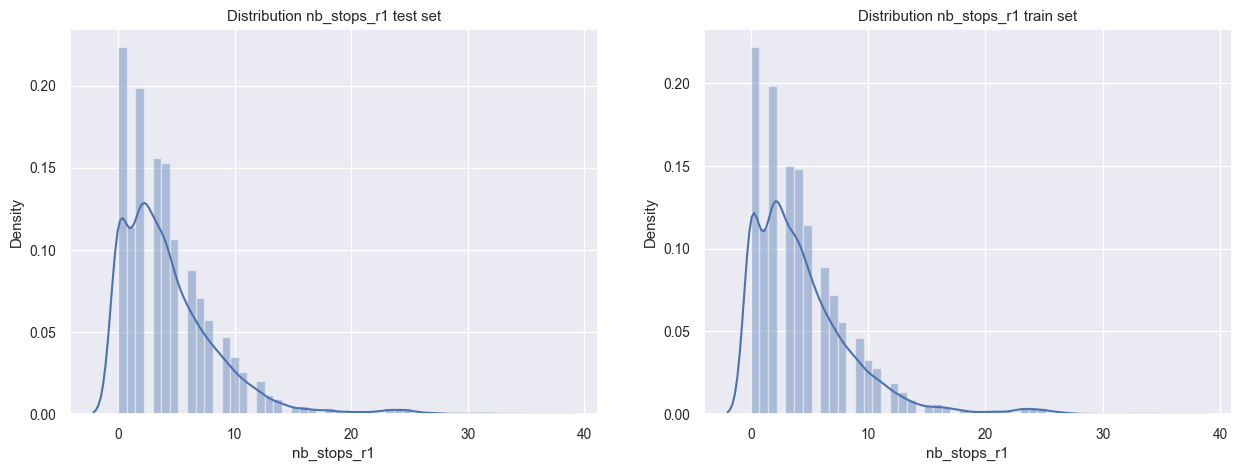

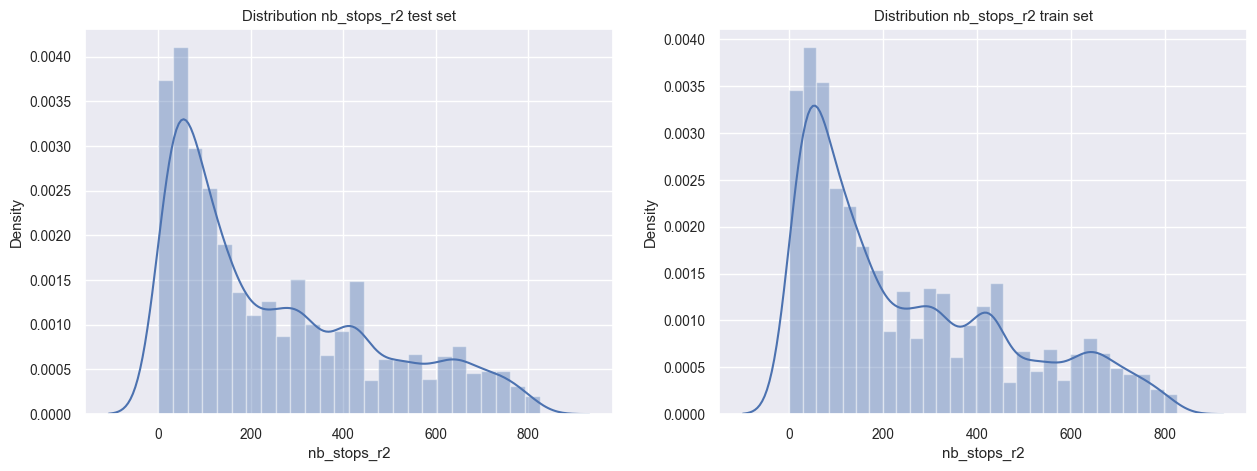

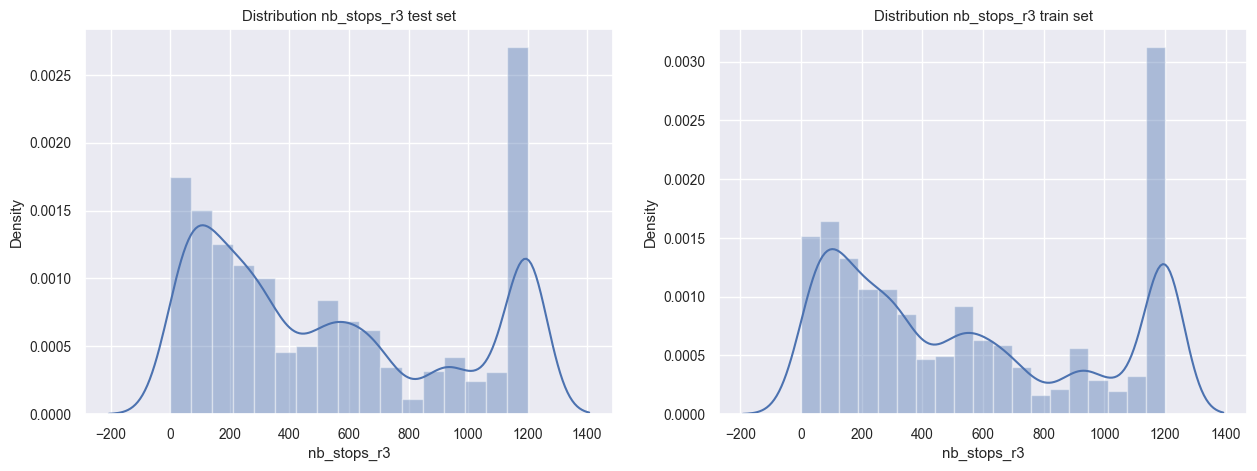

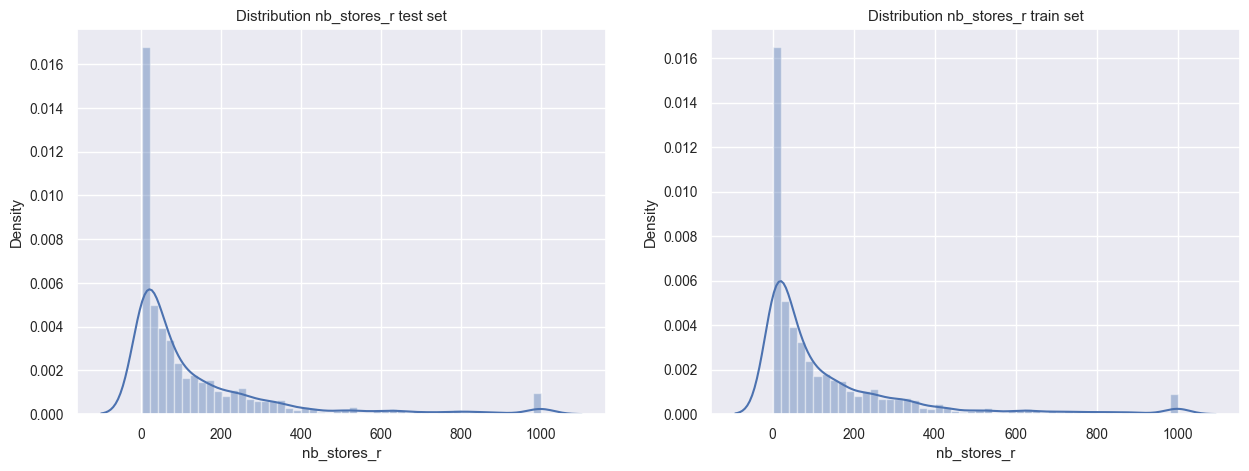

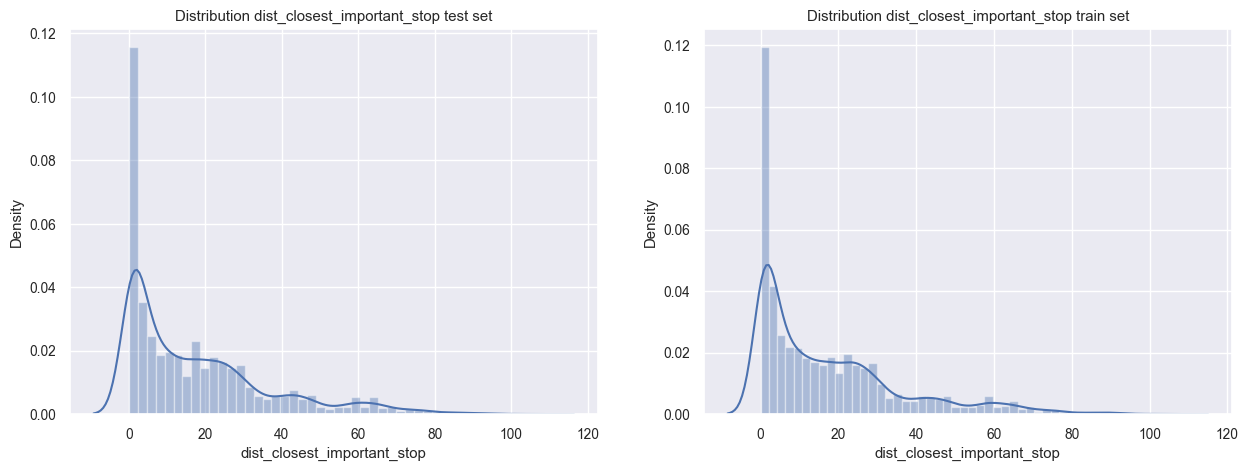

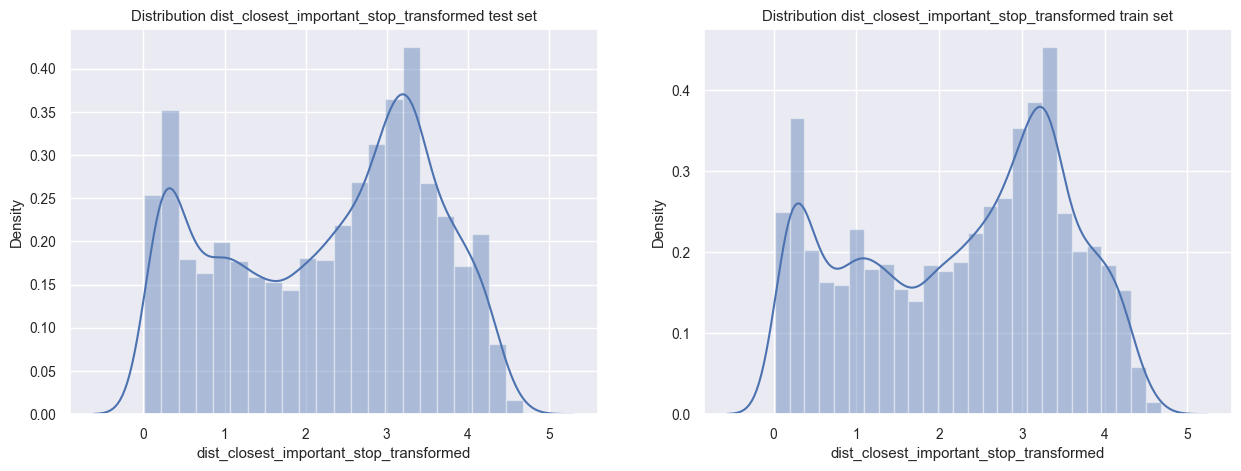

In [156]:
le = LabelEncoder()
sns.set(font_scale=0.9)

selected_cols = [
                 #'dist_closest_bus_transformed',
                 'nb_stops_r1',
                 'nb_stops_r2',
                 'nb_stops_r3',
                 #'dist_closest_comp_km',
                #'dist_closest_comp_km_transform',
                #'dist_closest_chain_km',
                #'dist_closest_chain_km_transform',
                #'lv2_desc',
                #'lv3_desc',
                'nb_stores_r',
                'dist_closest_important_stop',
                'dist_closest_important_stop_transformed',]

for col_name in selected_cols:#stores_test:
    
    if col_name =='income_classification':
        
        stores_test[col_name] = le.fit_transform(stores_test[col_name])
        stores_train[col_name] = le.fit_transform(stores_train[col_name])
            
    elif stores_test[col_name].dtypes != 'object':
        stores_test[col_name] = stores_test[col_name]
        stores_train[col_name] = stores_train[col_name]
        
    else:
        stores_test[col_name] = le.fit_transform(stores_test[col_name])
        stores_train[col_name] = le.fit_transform(stores_train[col_name])
        
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
    sns.distplot(stores_test[col_name], ax=ax1);
    ax1.set_title(f"Distribution {col_name} test set");
    sns.distplot(stores_train[col_name], ax=ax2);
    ax2.set_title(f"Distribution {col_name} train set");
    plt.show()
        
    #break # comment out to show all plots


# ___________ _3. Machine Learning Models and Predictions_ ___________


### Helper functions

In [46]:
def convert_DType_LGBM(dFrame,model_2=False):
    le = LabelEncoder()
    X = pd.DataFrame()
    
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        elif col_name == 'has_chain':
            X[col_name] = dFrame[col_name].astype('category')
        
        else:
            X[col_name] = dFrame[col_name]
    
    
    if model_2:
        X['grunnkrets_id'] = X['grunnkrets_id'].astype('category')
        remove_columns(X,['sales_channel_name',
                            'grunnkrets_id',
                            'lat',
                            'lon',
                            #'lat_rad',
                            #'lon_rad',
                            'chain_name',
                            'mall_name',
                            'has_chain',
                            'municipality_name',
                            'district_name',
                            'lv2_desc',
                            'lv3_desc',
                            #'income_gk',
                            #'income_district',
                            'income_classification',
                            #'tot_people_district',
                            'dist_closest_bus',
                            #'dist_closest_bus_transformed',
                            'nb_stops_r1',
                            #'nb_stops_r2',
                            #'nb_stops_r3',
                            'dist_closest_comp_km',
                            #'dist_closest_comp_km_transform',
                            #'dist_closest_chain_km_transform',
                            'city',
                            #'people_density_district_log'
                            ])
        
    
    return X

    # The encoding below gave a magnificent local rmsle but terrible on kaggle
    """le = LabelEncoder()
    X = pd.DataFrame()
    
    for col_name in dFrame:
        if col_name == 'plaace_hierarchy_id' or col_name == 'sales_channel_name' or col_name == 'municipality_name':
            X[col_name] = le.fit_transform(dFrame[col_name])
            
        elif dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        #elif col_name == 'grunnkrets_id':
        #    X[col_name] = le.fit_transform(dFrame[col_name])
        
        else:
            X[col_name] = dFrame[col_name]
    
    return X"""


In [18]:
def convert_DType_CatBoost(dFrame):
    X = pd.DataFrame()
    for col_name in dFrame:
        
        if col_name == 'grunnkrets_id':
            X[col_name] = dFrame[col_name]#.astype('category')
        
        #elif col_name == 'mall_name':   
        #    X[col_name] = dFrame[col_name].astype(str)# try fillna and category type
        
        #elif col_name == 'income_classification':
        #    X[col_name] = dFrame[col_name].astype('category')

        elif dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        else:
            X[col_name] = dFrame[col_name]
    
    return X


In [19]:
def convert_DType_XGBoost(dFrame):
    X = pd.DataFrame()
    le = LabelEncoder()
    for col_name in dFrame:
        
        if col_name =='income_classification':
            X[col_name] = le.fit_transform(dFrame[col_name])
            
        elif dFrame[col_name].dtypes != 'object':
            X[col_name] = dFrame[col_name]
        else:
            X[col_name] = le.fit_transform(dFrame[col_name])

    
    return X

In [84]:
def convert_DType_RFR(dFrame):
    X = pd.DataFrame()
    le = LabelEncoder()
    ohe = OneHotEncoder()
    oe = OrdinalEncoder(categories=[['low','medium','high']])
    
    for col_name in dFrame:
        
        if col_name =='income_classification':
            X[col_name] = oe.fit_transform(dFrame[col_name])
            
        elif dFrame[col_name].dtypes != 'object':
            X[col_name] = dFrame[col_name]
        else:
            X[dFrame[col_name].unique()] = ohe.fit_transform(dFrame[[col_name]])

    
    return X

Load train data and divide into test and train

In [57]:
def get_data(test_size=0.20,include_bad_columns=False,include_submission_set=True, split_cols_revenue=True, split=True):
    stores_train = pd.read_csv('data/stores_train.csv')
    stores_test = pd.read_csv('data/stores_test.csv')


    # Add features
    stores_train = add_selected_columns(stores_train, include_bad_columns=include_bad_columns)
    if include_submission_set:
        stores_test = add_selected_columns(stores_test, include_bad_columns=include_bad_columns)


    # Divide data into train and test set
    if(split_cols_revenue):
        x_train = stores_train.drop('revenue', axis=1)
    else: 
        x_train = stores_train

    y_train = stores_train['revenue']
    y_train=np.log1p(y_train) #log transform revenue

    if split:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=3)
        if include_submission_set:
            return  x_train, x_test, y_train, y_test, stores_test
        else:
            return  x_train, x_test, y_train, y_test
    else:
        if include_submission_set:
            return x_train, y_train, stores_test
        else:
            return x_train, y_train


#### Load data

In [77]:
x_train_t, x_test_t, y_train_t, y_test_t = get_data(include_submission_set=False)
print(x_train_t.dtypes)

plaace_hierarchy_id                  object
sales_channel_name                   object
chain_name                           object
mall_name                            object
has_chain                             int64
lat_rad                             float64
lon_rad                             float64
dist_closest_comp_km                float64
dist_closest_comp_km_transform      float64
dist_closest_chain_km_transform     float64
dist_closest_bus                    float64
nb_stops_r1                           int64
nb_stops_r2                           int64
nb_stops_r3                           int64
lv2_desc                             object
lv3_desc                             object
municipality_name                    object
district_name                        object
income_gk                           float64
income_classification              category
tot_people_district                 float64
city                                 object
people_density_district_log     

#### LightGBM


In [49]:
# Load data
LGBM_x_train_1, LGBM_x_test_1, y_train_1, y_test_1 = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
LGBM_x_train_1 = convert_DType_LGBM(LGBM_x_train_1)
LGBM_x_test_1 = convert_DType_LGBM(LGBM_x_test_1)
categorical_features = [
    f for f in LGBM_x_train_1.columns if LGBM_x_train_1[f].dtype == 'category'
]
print(categorical_features)
print(LGBM_x_train_1.dtypes)
# Make model, fit and predict
# Params obtained trough verstack optimization in the model interpretation part and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#LGBM_parameters = {'learning_rate': 0.005, 'num_leaves': 97, 'colsample_bytree': 0.742655098098731, 'subsample': 0.6006487354682485, 'verbosity': -1, 'random_state': 42, 'objective': 'regression', 'metric': 'l2', 'num_threads': 6, 'reg_alpha': 0.0008764689228295414, 'min_sum_hessian_in_leaf': 2.6613399574213243, 'reg_lambda': 1.0741663161049784e-08, 'n_estimators': 1000}
LGBM_parameters = {}
    
LGBM_model_1 = LGBMRegressor(**LGBM_parameters)
LGBM_model_1.fit(LGBM_x_train_1, y_train_1,categorical_feature=categorical_features)
LGBM_pred_1 = LGBM_model_1.predict(LGBM_x_test_1)
LGBM_pred_1=np.expm1(LGBM_pred_1) #invert log transform

# Run some tests
number_of_negatives = 0
for i in range(len(LGBM_pred_1)):
    if LGBM_pred_1[i] < 0.0:
        number_of_negatives += 1
        LGBM_pred_1[i] = 0.0
print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test_1,LGBM_pred_1)}")

['plaace_hierarchy_id', 'sales_channel_name', 'chain_name', 'mall_name', 'has_chain', 'lv2_desc', 'lv3_desc', 'municipality_name', 'district_name', 'income_classification', 'city']
plaace_hierarchy_id                category
sales_channel_name                 category
chain_name                         category
mall_name                          category
has_chain                          category
lat_rad                             float64
lon_rad                             float64
dist_closest_comp_km                float64
dist_closest_comp_km_transform      float64
dist_closest_chain_km_transform     float64
dist_closest_bus                    float64
nb_stops_r1                           int64
nb_stops_r2                           int64
nb_stops_r3                           int64
lv2_desc                           category
lv3_desc                           category
municipality_name                  category
district_name                      category
income_gk                  

In [ ]:
# Load data
LGBM_x_train_2, LGBM_x_test_2, y_train_2, y_test_2 = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
LGBM_x_train_2 = convert_DType_LGBM(LGBM_x_train_2, model_2=True)
LGBM_x_test_2 = convert_DType_LGBM(LGBM_x_test_2, model_2=True)
print(LGBM_x_train_2.dtypes)
# Make model, fit and predict
# Params obtained trough verstack optimization in the model interpretation part and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#LGBM_parameters = {'learning_rate': 0.005, 'num_leaves': 97, 'colsample_bytree': 0.742655098098731, 'subsample': 0.6006487354682485, 'verbosity': -1, 'random_state': 42, 'objective': 'regression', 'metric': 'l2', 'num_threads': 6, 'reg_alpha': 0.0008764689228295414, 'min_sum_hessian_in_leaf': 2.6613399574213243, 'reg_lambda': 1.0741663161049784e-08, 'n_estimators': 1000}
LGBM_parameters = {}
    
LGBM_model_2 = LGBMRegressor(**LGBM_parameters)
LGBM_model_2.fit(LGBM_x_train_2, y_train_2)
LGBM_pred_2 = LGBM_model_2.predict(LGBM_x_test_2)
LGBM_pred_2=np.expm1(LGBM_pred_2) #invert log transform

# Run some tests
number_of_negatives = 0
for i in range(len(LGBM_pred_2)):
    if LGBM_pred_2[i] < 0.0:
        number_of_negatives += 1
        LGBM_pred_2[i] = 0.0
print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test_2,LGBM_pred_2)}")

#### Catboost

In [25]:
# Load data
CB_x_train, CB_x_test, y_train, y_test = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
CB_x_train = convert_DType_CatBoost(CB_x_train)
CB_x_test = convert_DType_CatBoost(CB_x_test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category'))[0]
print(categorical_features_indices)
print(CB_x_train.dtypes)
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

# Make model, fit and predict
# params found with gridsearch in the model interpretation part and some testing on our own
#CB_parameters = {'depth': 8, 'iterations': 1500, 'learning_rate': 0.005, 'use_best_model': True}
CB_parameters = {}

CB_model = cb.CatBoostRegressor(loss_function='RMSE', **CB_parameters, verbose=0)
CB_model.fit( CB_x_train, y_train, cat_features=categorical_features_indices, eval_set=test_pool, use_best_model=True, plot=False)
CB_pred = CB_model.predict(CB_x_test)
CB_pred = np.expm1(CB_pred)


# Run some tests
print(f"rmsle: {rmsle(y_test,CB_pred)}")


[ 0  1  2  3 14 15 16 17 19 21]
plaace_hierarchy_id                category
sales_channel_name                 category
chain_name                         category
mall_name                          category
has_chain                             int64
lat_rad                             float64
lon_rad                             float64
dist_closest_comp_km                float64
dist_closest_comp_km_transform      float64
dist_closest_chain_km_transform     float64
dist_closest_bus                    float64
nb_stops_r1                           int64
nb_stops_r2                           int64
nb_stops_r3                           int64
lv2_desc                           category
lv3_desc                           category
municipality_name                  category
district_name                      category
income_gk                           float64
income_classification              category
tot_people_district                 float64
city                               category


#### XGBoost

In [26]:

# Load data
XG_x_train, XG_x_test, y_train, y_test = x_train_t, x_test_t, y_train_t, y_test_t

# Convert to approperiate dtypes
XG_x_train = convert_DType_XGBoost(XG_x_train)
XG_x_test = convert_DType_XGBoost(XG_x_test)

print(XG_x_train.dtypes)

# Make model, fit and predict
XG_parameters = {}

XG_model = xg.XGBRegressor(**XG_parameters)#,tree_method="gpu_hist", enable_categorical=True)
XG_model.fit(XG_x_train,y_train)
XG_pred = XG_model.predict(XG_x_test)
XG_pred = np.expm1(XG_pred)


# Run some tests
number_of_negatives = 0
for i in range(len(XG_pred)):
    if XG_pred[i] < 0.0:
        number_of_negatives += 1
        XG_pred[i] = 0.0

print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,XG_pred)}")

plaace_hierarchy_id                  int64
sales_channel_name                   int64
chain_name                           int64
mall_name                            int64
has_chain                          float64
lat_rad                            float64
lon_rad                            float64
dist_closest_comp_km               float64
dist_closest_comp_km_transform     float64
dist_closest_chain_km_transform    float64
dist_closest_bus                   float64
nb_stops_r1                        float64
nb_stops_r2                        float64
nb_stops_r3                        float64
lv2_desc                             int64
lv3_desc                             int64
municipality_name                    int64
district_name                        int64
income_gk                          float64
income_classification                int64
tot_people_district                float64
city                                 int64
people_density_district_log        float64
dtype: obje

#### Random forest regressor

In [85]:
RFR_x_train, RFR_x_test, y_train, y_test = x_train_t, x_test_t, y_train_t, y_test_t

RFR_parameters = {}

RFR_model = RandomForestRegressor(**RFR_parameters)
RFR_x_train = convert_DType_RFR(RFR_x_train)


RFR_model.fit(RFR_x_train, y_train_t)

RFR_pred = RFR_model.predict(RFR_x_test)
RFR_pred = np.expm1(RFR_pred)



print(f"rmsle: {rmsle(y_test,RFR_pred)}")

TypeError: fit_transform() missing 1 required positional argument: 'colname'

#### AutoML

In [ ]:


""" from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
h2o.init()

# import the boston dataset:
# this dataset looks at features of the boston suburbs and predicts median housing prices
# the original dataset can be found at https://archive.ics.uci.edu/ml/datasets/Housing
##boston = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/BostonHousing.csv")

#pandah2_x_train, pandah2_x_test, y_train, y_test, _ = get_data(dropRevenueCol = False)


dfh2 = h2o.H2OFrame(stores_train)
dftesting = h2o.H2OFrame(stores_test)



input_datatypes = {'key': 'datatype', ...


}





#dfh2 = h2o.import_file("data/stores_train.csv")
#dftesting = h2o.import_file("data/stores_test.csv")

# set the predictor columns
##predictors = boston.columns[:-1]
predsh2 = dfh2.columns[:-1]


# this example will predict the medv column
# you can run the following to see that medv is indeed a numeric value
##boston["medv"].isnumeric()
#fh2["revenue"].isnumeric()

# set the response column to "medv", which is the median value of owner-occupied homes in $1000's
##response = "medv"
resp = "revenue"


H2O

log rev


rmse lokal test


# convert the `chas` column to a factor
# `chas` = Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
##boston['chas'] = boston['chas'].asfactor()

# split into train and testing sets
##train, test = boston.split_frame(ratios = [0.8], seed = 1234)

#training, training2 = dfh2.split_frame(ratios = [0.9], seed = 1234)
#testing, testing2 = dftesting.split_frame(ratios = [0.9], seed =  1234)
training = dfh2
testing = dftesting
#training, testing = dfh2.split_frame(ratios = [0.8], seed = 1234)

# set the `alpha` parameter to 0.25
# then initialize the estimator then train the model
##boston_glm = H2OGeneralizedLinearEstimator(alpha = 0.25)
## boston_glm.train(x = predictors, y = response, training_frame = train)


## Auto ML
dfh2_auto = H2OAutoML(max_models=50, nfolds=6,  seed=2, stopping_metric="RMSE", exclude_algos="DeepLearning")
dfh2_auto.train(x = predsh2, y = resp, training_frame = training)
predictionsh2 = dfh2_auto.predict(testing)



## GLE
dfh2_glm = H2OGeneralizedLinearEstimator(alpha = 0.25)
dfh2_glm.train(x = predsh2, y = resp, training_frame = training)
predictionsh2 = dfh2_glm.predict(testing)

# predict using the model and the testing dataset
#predict = boston_glm.predict(test)




# View a summary of the prediction
print("det funka gitt") """;

AutoML2

In [ ]:
h2o.init()

In [ ]:
Data, _, _, _, test = get_data(test_size=0.001, split_cols_revenue=False, include_bad_columns=False)

In [ ]:
Data.dtypes
Data['revenue'] = np.log1p(Data['revenue'])

In [ ]:
AML_data = h2o.H2OFrame(Data)
AML_test = h2o.H2OFrame(test)

In [ ]:
AML_data.describe()

In [ ]:
AML_test.describe()

In [ ]:
AML_data_train, AML_data_test, AML_data_valid = AML_data.split_frame(ratios=[0.8,0.1])

In [ ]:
y = 'revenue'
x = AML_data.columns
x.remove(y)

In [ ]:
AML = H2OAutoML(max_models=50,seed=42,exclude_algos=['DeepLearning'], verbosity='info', nfolds=0)

In [ ]:
AML.train(x=x,y=y,training_frame=AML_data_train, validation_frame=AML_data_valid)

In [ ]:
lb = AML.leaderboard

In [ ]:
lb.head(20)

In [ ]:
predicted_prices=AML.predict(AML_test)
print(predicted_prices)
predicted_prices = predicted_prices.as_data_frame()
predicted_prices = predicted_prices["predict"].to_numpy()
predicted_prices_logged=predicted_prices

In [ ]:
AML_pred = np.expm1(predicted_prices_logged)

In [ ]:
stores_test = pd.read_csv('data/stores_test.csv')
#write the predicition to file
writeResultToFile(stores_test, AML_pred, "AML_Louis_4")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/AML_Louis_4.csv')
submissionVery.info()

#### Compare models

In [53]:
def compare_preds_func():
    compare_preds = pd.DataFrame()
    compare_preds['true'] = y_test
    compare_preds['median'] = np.median([CB_pred,LGBM_pred,XG_pred],axis=0)
    compare_preds['mean'] = np.mean([CB_pred,LGBM_pred,XG_pred],axis=0)
    compare_preds['catboost'] = CB_pred
    compare_preds['lightgbm'] = LGBM_pred
    compare_preds['XGBoost'] = XG_pred
    compare_preds['Median err'] = np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test)
    compare_preds['Mean err'] = np.abs(np.mean([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test)
    compare_preds['CB err'] = np.abs(CB_pred - y_test)
    compare_preds['LGBM err'] = np.abs(LGBM_pred - y_test)
    compare_preds['XG err'] = np.abs(XG_pred - y_test)

    
    print(f" Sum Err Mean:   {np.sum(compare_preds['Mean err'])}")
    print(f" Sum Err Median: {np.sum(compare_preds['Median err'])}")
    print(f" Sum Err CB:     {np.sum(compare_preds['CB err'])}")
    print(f" Sum Err LGBM:   {np.sum(compare_preds['LGBM err'])}")
    print(f" Sum Err XG :    {np.sum(compare_preds['XG err'])}")

    print(f" Mean Err Mean:   {np.mean(compare_preds['Mean err'])}")
    print(f" Mean Err Median: {np.mean(compare_preds['Median err'])}")
    print(f" Mean Err CB:     {np.mean(compare_preds['CB err'])}")
    print(f" Mean Err LGBM:   {np.mean(compare_preds['LGBM err'])}")
    print(f" Mean Err XG:     {np.mean(compare_preds['XG err'])}")

    print(f" RSMLE mean:      {rmsle(y_test, ((CB_pred + LGBM_pred + XG_pred)/3))}")
    print(f" RSMLE Median:    {rmsle(y_test, np.median([CB_pred,LGBM_pred,XG_pred],axis=0))}")
    print(f" RSMLE LGBM:      {rmsle(y_test, LGBM_pred)}")
    print(f" RSMLE CB:        {rmsle(y_test, CB_pred)}")
    print(f" RSMLE XG:        {rmsle(y_test, XG_pred)}")

    print(f" \n Combos")
    print(f" RSMLE CB & LGBM:    {rmsle(y_test, ((CB_pred + LGBM_pred)/2))}")
    print(f" RSMLE CB & XG:      {rmsle(y_test, ((CB_pred + XG_pred)/2))}")
    print(f" RSMLE XG & LGBM:    {rmsle(y_test, ((LGBM_pred + XG_pred)/2))}")
    print(f" RSMLE Mean:         {rmsle(y_test, ((CB_pred + LGBM_pred + XG_pred)/3))}")
    print(f" RSMLE Median:       {rmsle(y_test, np.median([CB_pred,LGBM_pred,XG_pred],axis=0))}")
    print()
    print(f" Sum Err CB & LGBM:  {np.sum(np.abs((CB_pred+LGBM_pred)/2 - y_test))}")
    print(f" Sum Err CB & XG:    {np.sum(np.abs((CB_pred+XG_pred)/2 - y_test))}")
    print(f" Sum Err XG & LGBM:  {np.sum(np.abs((LGBM_pred+XG_pred)/2 - y_test))}")
    print(f" Sum Err Mean:       {np.sum(np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test))}")
    print(f" Sum Err Median:     {np.sum(np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test))}")
    print()
    print(f" Mean Err CB & LGBM: {np.mean(np.abs((CB_pred+LGBM_pred)/2 - y_test))}")
    print(f" Mean Err CB & XG:   {np.mean(np.abs((CB_pred+XG_pred)/2 - y_test))}")
    print(f" Mean Err XG & LGBM: {np.mean(np.abs((LGBM_pred+XG_pred)/2 - y_test))}")
    print(f" Mean Err mean:      {np.mean(np.abs((CB_pred+LGBM_pred+XG_pred)/3 - y_test))}")
    print(f" Mean Err Median:    {np.mean(np.abs(np.median([CB_pred,LGBM_pred,XG_pred],axis=0) - y_test))}")


#compare_preds_func()

## Predict test and submit

In [58]:
CB_parameters = {}#'depth': 12, 'iterations': 3000, 'learning_rate': 0.002, 'use_best_model': True}
LGBM_parameters = {}#'learning_rate': 0.002, 'n_estimators': 2000}

x_train, y_train, test = get_data(split=False)

In [106]:
# Load data
x_train, x_test, y_train, y_test, test = get_data(test_size=0.0001)
#x_train, y_train, test = get_data(split=False)
print(x_train.columns)

# Convert to approperiate dtypes
LGBM_x_train_1 = convert_DType_LGBM(x_train)
LGBM_test_1 = convert_DType_LGBM(test)
categorical_features = [f for f in LGBM_x_train_1.columns if LGBM_x_train_1[f].dtype == 'category']

""" LGBM_x_train_2 = convert_DType_LGBM(x_train, model_2=True)
LGBM_test_2 = convert_DType_LGBM(test, model_2=True) """

CB_x_train = convert_DType_CatBoost(x_train)
#CB_x_test = convert_DType_CatBoost(x_test)
CB_test = convert_DType_CatBoost(test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
#test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

XG_x_train = convert_DType_XGBoost(x_train)
XG_test = convert_DType_XGBoost(test)

# Confirm correct feats
print(f"LGBM:\n{LGBM_x_train_1.dtypes}\n")
print(f"CB:\n{categorical_features_indices}\n{CB_x_train.dtypes}\n")
print(f"XG:\n{XG_x_train.dtypes}\n")

# LGBM_1
LGBM_model_1 = LGBMRegressor(**LGBM_parameters)
LGBM_model_1.fit(LGBM_x_train_1, y_train, categorical_feature=categorical_features)
LGBM_pred_1 = LGBM_model_1.predict(LGBM_test_1)
#LGBM_pred=np.expm1(LGBM_pred) #invert log transform

""" # LGBM_2
LGBM_model_2 = LGBMRegressor(**LGBM_parameters)
LGBM_model_2.fit(LGBM_x_train_2, y_train)
LGBM_pred_2 = LGBM_model_2.predict(LGBM_test_2) """


# Catboost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', **CB_parameters, silent=True)
CB_model.fit(CB_x_train,y_train, cat_features=categorical_features_indices)#, eval_set=test_pool, use_best_model=True)
CB_pred = CB_model.predict(CB_test)
#CB_pred = np.expm1(CB_pred)

# XGBoost
XG_model = xg.XGBRegressor(**XG_parameters)
XG_model.fit(XG_x_train,y_train)
XG_pred = XG_model.predict(XG_test)
XG_pred = np.expm1(XG_pred)

# Aggregate result
PREDICTION = np.expm1(np.mean([CB_pred, LGBM_pred_1],axis=0))

Index(['plaace_hierarchy_id', 'sales_channel_name', 'chain_name', 'mall_name',
       'has_chain', 'lat_rad', 'lon_rad', 'dist_closest_comp_km',
       'dist_closest_comp_km_transform', 'dist_closest_chain_km_transform',
       'nb_stores_r', 'dist_closest_bus', 'nb_stops_r1', 'nb_stops_r2',
       'nb_stops_r3', 'lv2_desc', 'lv3_desc', 'municipality_name',
       'district_name', 'income_gk', 'income_classification',
       'tot_people_district', 'city', 'people_density_district_log'],
      dtype='object')
LGBM:
plaace_hierarchy_id                category
sales_channel_name                 category
chain_name                         category
mall_name                          category
has_chain                          category
lat_rad                             float64
lon_rad                             float64
dist_closest_comp_km                float64
dist_closest_comp_km_transform      float64
dist_closest_chain_km_transform     float64
nb_stores_r                           in

In [107]:
stores_test = pd.read_csv('data/stores_test.csv')
#write the predicition to file
writeResultToFile(stores_test, PREDICTION, "mean_no_hyper_storesR")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/mean_no_hyper_storesR.csv')
submissionVery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8577 non-null   object 
 1   predicted  8577 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.1+ KB


# ___________ _4. Model Interpretations_ ___________

## Parameter Optimization

Load data

In [178]:
x_train, x_test, y_train, y_test = get_data(include_bad_columns=False,include_submission_set=False)

In [ ]:
#remove_columns(x_test,['mean_rev_district_log'])

#### Lightgbm


learning_rate                    : 0.02
num_leaves                       : 184
colsample_bytree                 : 0.6431728084931179
subsample                        : 0.8173812867345227
verbosity                        : -1
random_state                     : 42
objective                        : regression
metric                           : l2
num_threads                      : 6
reg_alpha                        : 2.2815168125057886e-05
min_sum_hessian_in_leaf          : 0.013496096867645814
reg_lambda                       : 5.1564241712706785e-05
n_estimators                     : 138


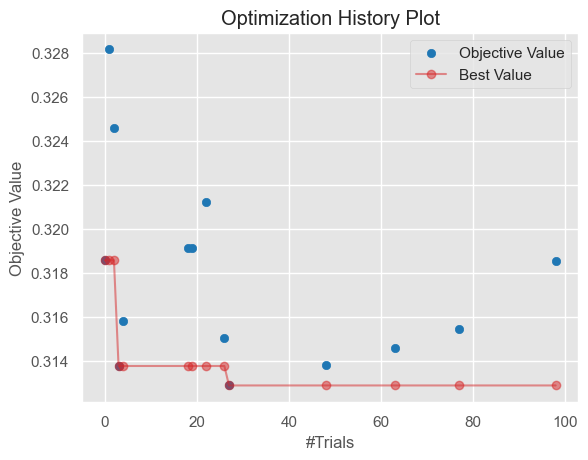

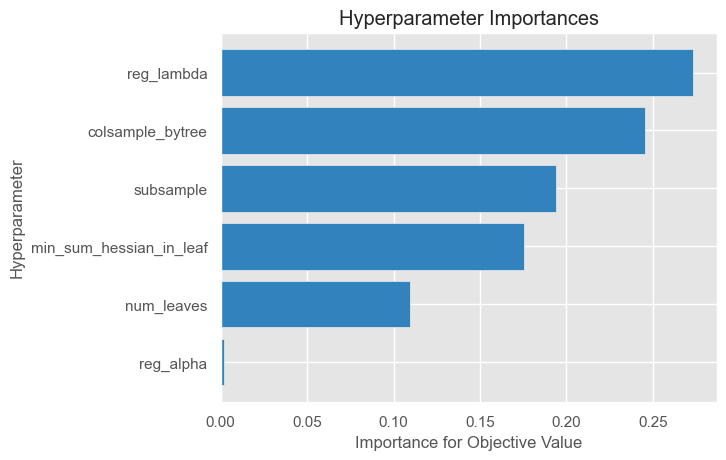

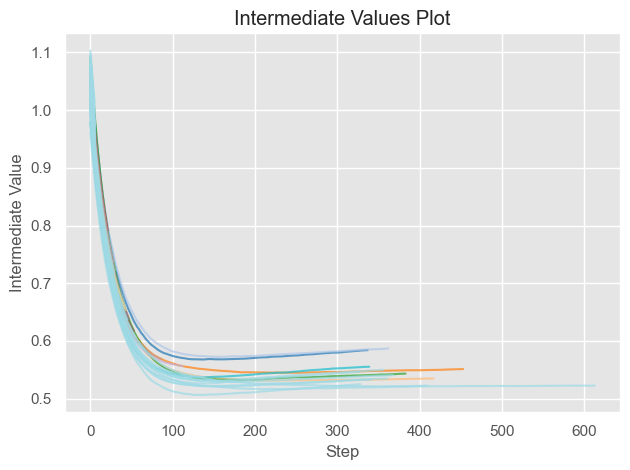

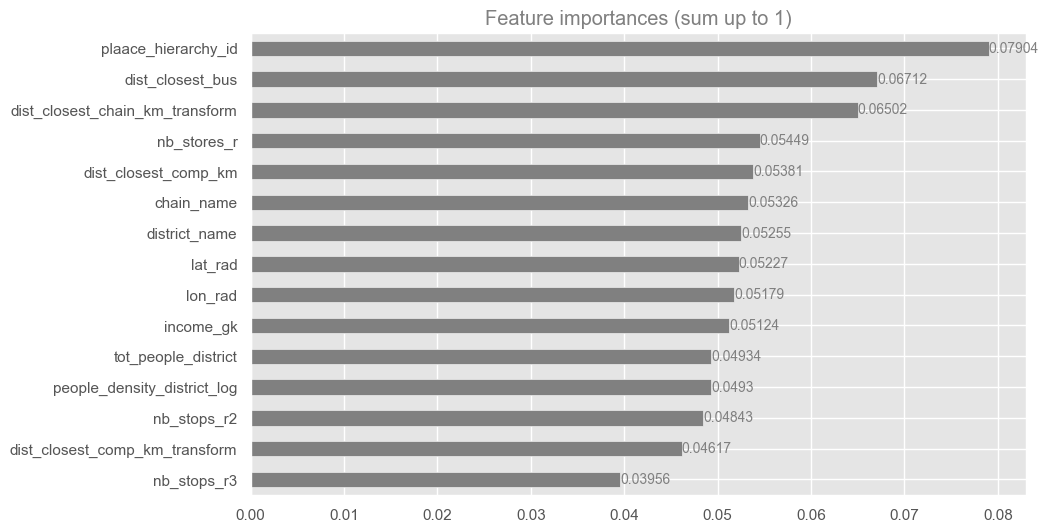



Time elapsed for fit execution: 1 min 41.007 sec


In [104]:
LGBM_x_train = convert_DType_LGBM(x_train)
cat_columns = LGBM_x_train.select_dtypes(['category']).columns
LGBM_x_train[cat_columns] = LGBM_x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])

sns.set(font_scale=1)
tuner = LGBMTuner(metric = 'rmsle', verbosity=0);
tuner.fit(LGBM_x_train, y_train);


CatBoost

In [179]:
# Gridsearch best hyperparameters
CB_x_train = convert_DType_CatBoost(x_train)
CB_x_test = convert_DType_CatBoost(x_test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )
CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)

grid = {'iterations': [2000],
        'learning_rate': [0.005, 0.01],
        'depth': [8, 10, 12, 13],
        'use_best_model': [True]}
""" grid = GridSearchCV(estimator=CB_model, param_grid=grid, cv=2, n_jobs=1, verbose=0)
grid.fit(CB_x_train, y_train, eval_set=test_pool)"""

' grid = GridSearchCV(estimator=CB_model, param_grid=grid, cv=2, n_jobs=1, verbose=0)\ngrid.fit(CB_x_train, y_train, eval_set=test_pool)'

#### Print Best parameters

In [ ]:
print(f" \n Best params LGBM: {tuner.best_params}\n")
#print(f" Best params CB: {grid.best_params_}")

## Feature importance

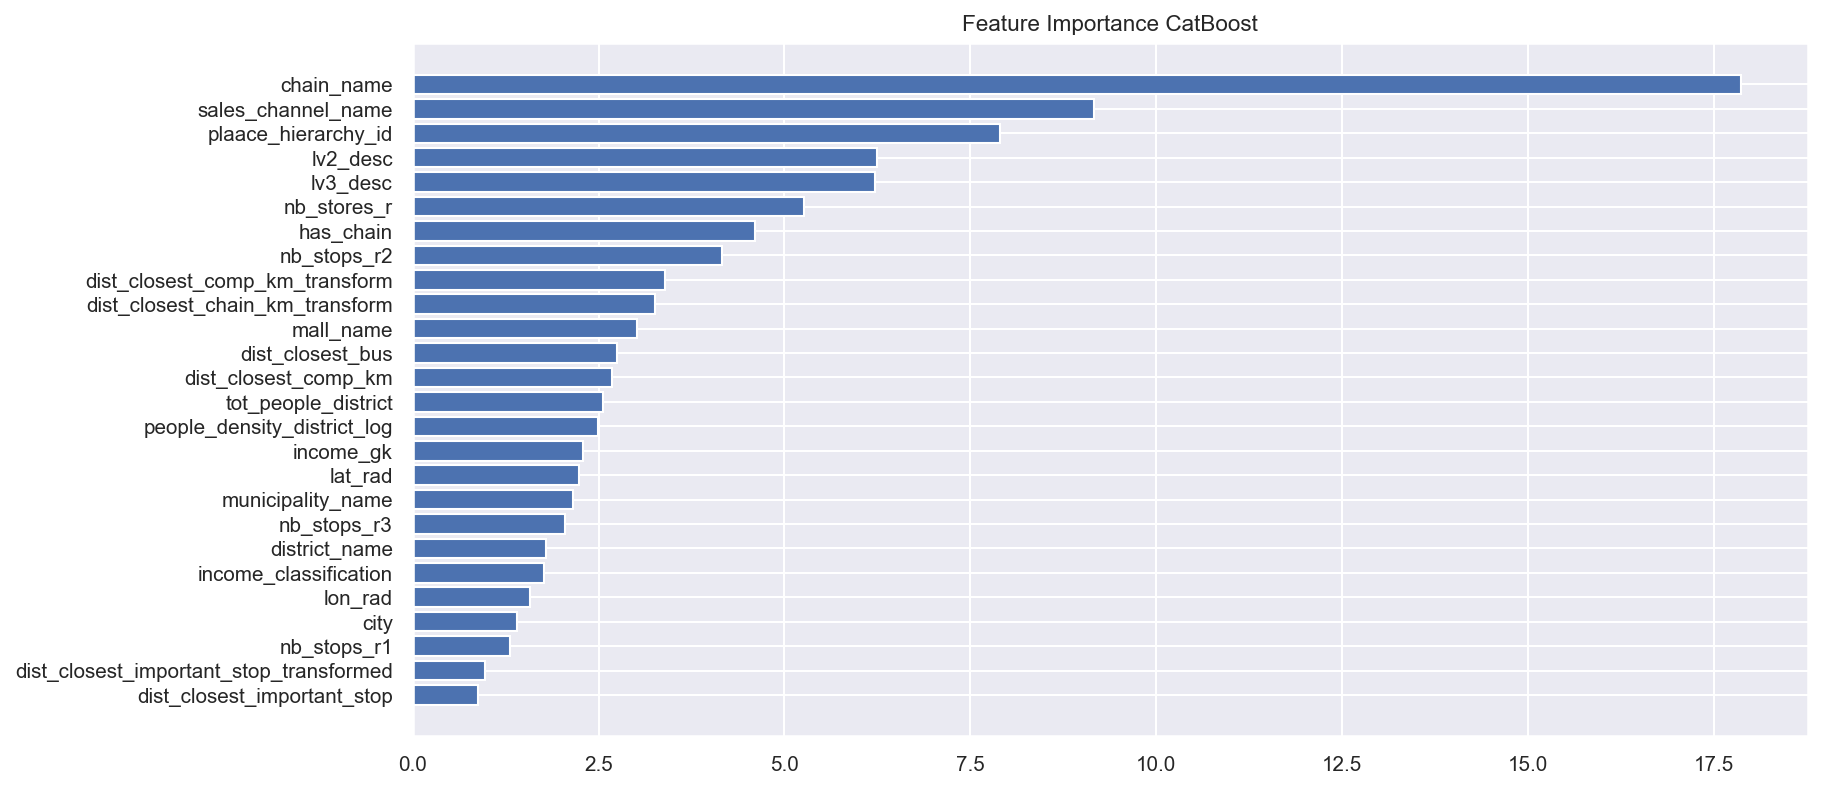

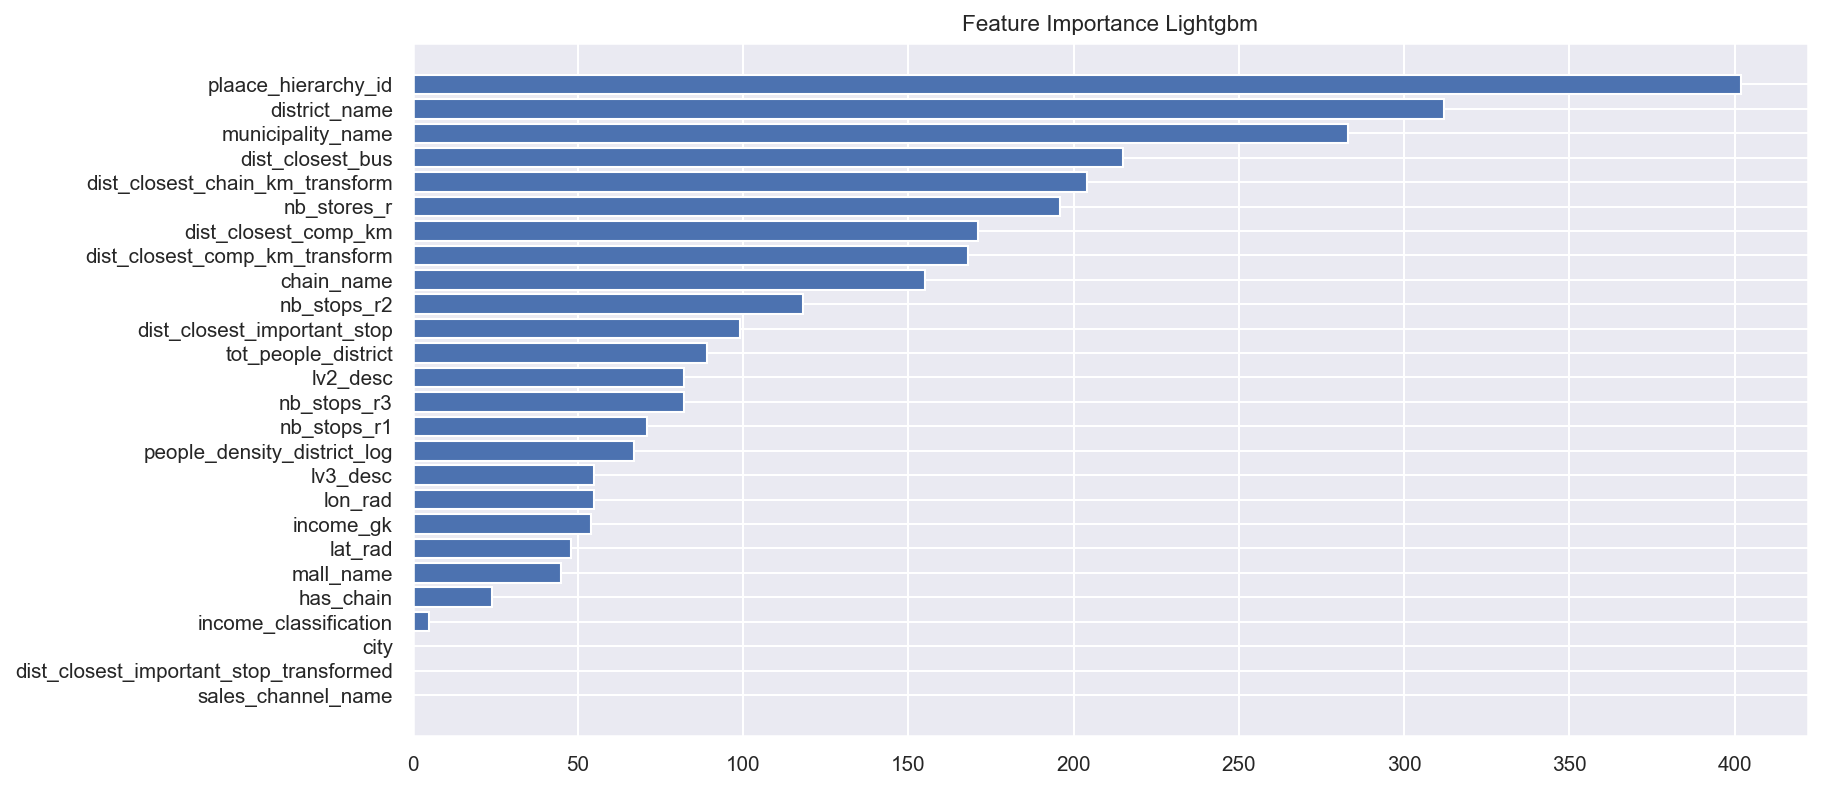

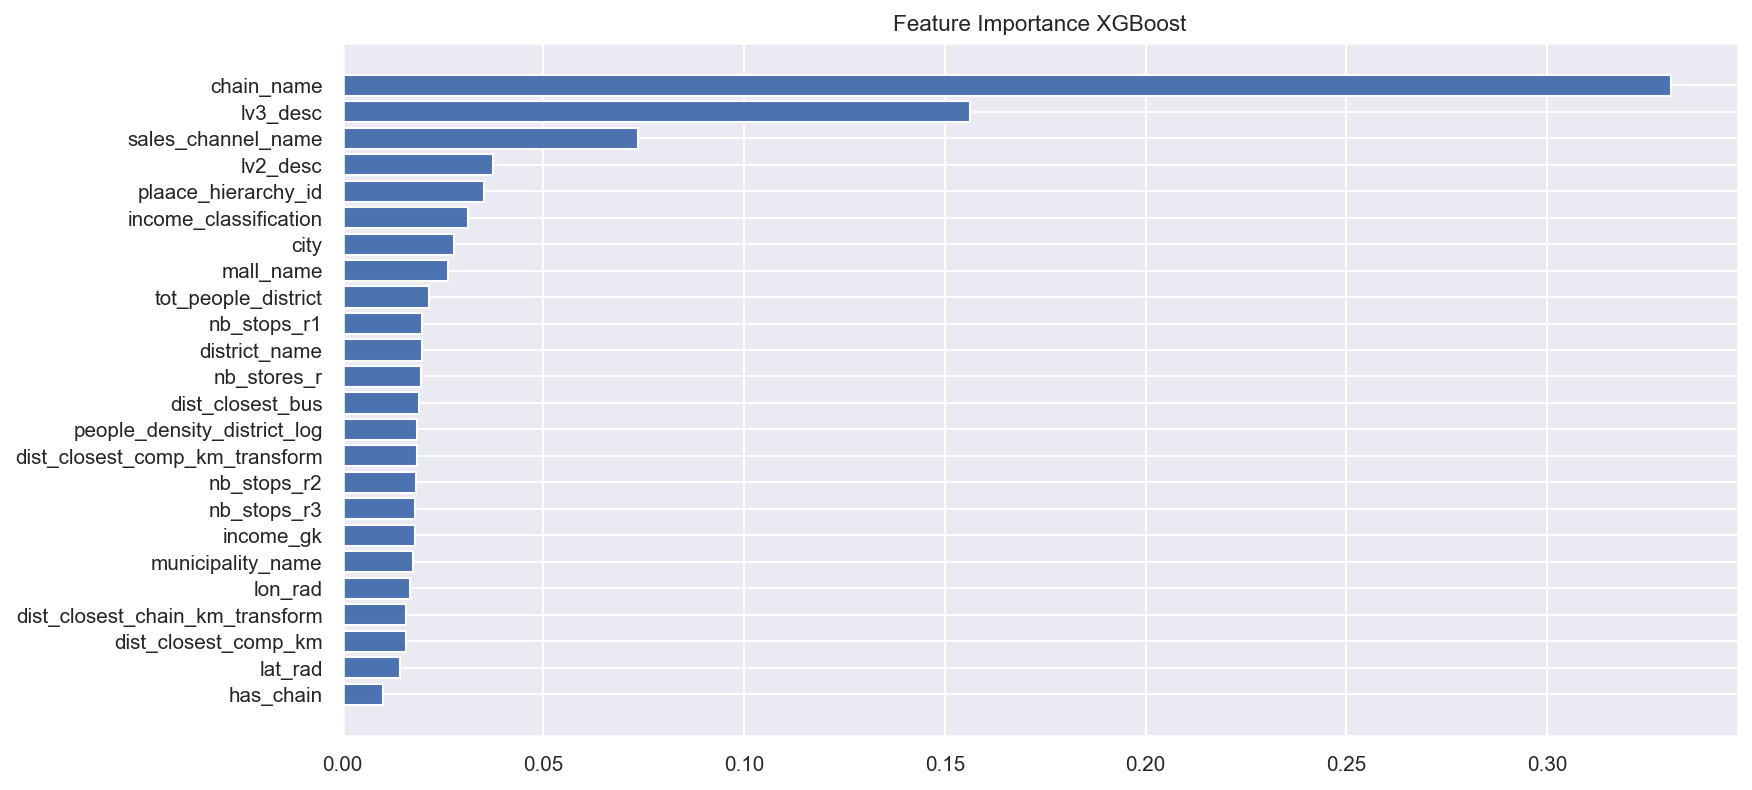

In [180]:
# Feature importance

# lightGBM
#tuner.plot_importances()

# catBoost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)
CB_model.fit(CB_x_train, y_train, eval_set=test_pool)

# CatBoost
CB_f_imp = CB_model.feature_importances_
sorted_idx = np.argsort(CB_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), CB_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(CB_x_train.columns)[sorted_idx])
plt.title('Feature Importance CatBoost')
plt.show()

# LightGBM
LGBM_x_train = convert_DType_LGBM(x_train)
categorical_features = [f for f in LGBM_x_train.columns if LGBM_x_train[f].dtype == 'category']
LGBM_model = lgb.LGBMRegressor(**LGBM_parameters)
LGBM_model.fit(LGBM_x_train, y_train, categorical_feature=categorical_features)

LGBM_f_imp = LGBM_model.feature_importances_
sorted_idx = np.argsort(LGBM_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), LGBM_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(LGBM_x_train.columns)[sorted_idx])
plt.title('Feature Importance Lightgbm')
plt.show()

# XGBoost
XG_f_imp = XG_model.feature_importances_
sorted_idx = np.argsort(XG_f_imp)

fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), XG_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(XG_x_train.columns)[sorted_idx])
plt.title('Feature Importance XGBoost')
plt.show()
#bokmerke


In [ ]:
tuner.feature_importances

## shap

In [36]:
shap.initjs()

In [37]:
explainer = shap.TreeExplainer(CB_model)
shap_values = explainer.shap_values(CB_x_train)
row=1

In [43]:
row+=1
shap.force_plot(explainer.expected_value, shap_values[row,:], CB_x_train.iloc[row,:])


In [ ]:
#shap.summary_plot(shap_values, CB_x_train)
shap.summary_plot(shap_values, CB_x_train, show=False, color_bar=False)
plt.show()